In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("../../data/hvac/minutes_a3.csv")

In [5]:
st = pd.HDFStore("../../data/hvac/weather_hvac_2013.h5")

In [15]:
df = st['/26_Y']

In [16]:
import statsmodels.api as sm


In [17]:
res = sm.tsa.seasonal_decompose(df.values, freq=60)

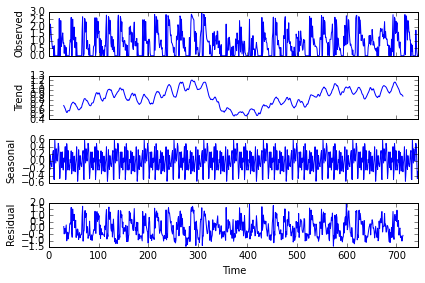

In [18]:
resplot = res.plot()

In [175]:
from itertools import chain, combinations

def powerset(iterable, N_max):
    xs = list(iterable)
    # note we return an iterator rather than a list
    
    return chain.from_iterable( combinations(xs,n) for n in range(N_max-1, N_max))
    

In [176]:
features = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3','a4','a5','a6','work_energy', 'sleep_energy', 'morning_energy', 
            'evening_energy','morning_mins', 'work_mins','sleep_mins', 'evening_mins','overall_energy', 'overall_mins']
features_small = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3']
features_mid = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3','work_energy','evening_energy','work_mins','evening_mins']

In [177]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [178]:
np.random.seed(42)


In [179]:
from sklearn import cross_validation
train_idx, test_idx = cross_validation.train_test_split(range(len(df)), train_size=0.5)


In [180]:
train = df.ix[train_idx]
test = df.ix[test_idx]

In [181]:
pd.value_counts(train.hvac_class)

Bad        19
Average    11
Good        2
dtype: int64

In [182]:
pd.value_counts(test.hvac_class)

Bad        19
Average    11
Good        3
dtype: int64

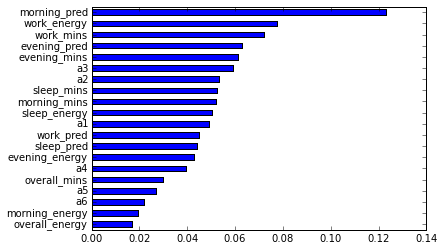

In [183]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
# fit an Extra Trees model to the data
np.random.seed(42)
model = ExtraTreesClassifier()
model.fit(train[features], train["hvac_class"])
# display the relative importance of each attribute
ser1 = pd.Series(model.feature_importances_, index=features)

np.random.seed(42)
model = ExtraTreesClassifier()
model.fit(test[features], test["hvac_class"])
# display the relative importance of each attribute
ser2 = pd.Series(model.feature_importances_, index=features)


ser = (ser1+ ser2)/2.0
ser.sort()
ser.plot(kind='barh')

In [184]:
ser1

sleep_pred        0.069399
morning_pred      0.174619
work_pred         0.061890
evening_pred      0.060952
a1                0.054190
a2                0.046950
a3                0.040717
a4                0.038899
a5                0.012292
a6                0.027190
work_energy       0.068360
sleep_energy      0.060751
morning_energy    0.016396
evening_energy    0.031719
morning_mins      0.026419
work_mins         0.093604
sleep_mins        0.034364
evening_mins      0.050584
overall_energy    0.011784
overall_mins      0.018919
dtype: float64

In [185]:
ser2

sleep_pred        0.019185
morning_pred      0.071391
work_pred         0.027573
evening_pred      0.064897
a1                0.044325
a2                0.059336
a3                0.077610
a4                0.039778
a5                0.041781
a6                0.016830
work_energy       0.086501
sleep_energy      0.040242
morning_energy    0.022793
evening_energy    0.053988
morning_mins      0.077709
work_mins         0.050875
sleep_mins        0.070258
evening_mins      0.072242
overall_energy    0.022237
overall_mins      0.040447
dtype: float64

In [186]:
y_pred = model.predict(df[features])
y_true = df["hvac_class"]
confusion_matrix(y_true, y_pred)
accuracy_score(y_true, y_pred)

0.83076923076923082

In [187]:

def accuracy_multiclass(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    length = len(confusion)
    out = 0.0
    for i in xrange(length):
        out+= confusion[i,i]*1.0/np.sum(confusion[i])
    return out/length
        

In [188]:
out_fold1 = {}
out_fold2 = {}
y1_best_score = 0
y1_best_pred = None
y2_best_score = 0
y2_best_pred = None
best_random_state = -1
best_random_score = 0


    
cls = {  "RF":RandomForestClassifier(), "DT": DecisionTreeClassifier()
      }
out_fold1[random_state] = {"SVM":{}, "DT":{},"KNN":{},"RF":{}, "ET":{}}

y_true = test['hvac_class']
for f in powerset(features):
    for cl_name, clf in cls.iteritems():

        np.random.seed(42)
        clf.fit(train[list(f)], train["hvac_class"])
        y_pred = clf.predict(test[list(f)])

        accur = accuracy_multiclass(y_pred, y_true)
        out_fold1[random_state][cl_name][f] = accur


out_fold2[random_state] = {"SVM":{}, "DT":{},"KNN":{},"RF":{}, "ET":{}}

y_true =train['hvac_class']
for f in powerset(features):
    np.random.seed(42)


    for cl_name, clf in cls.iteritems():
        clf.fit(test[list(f)], test["hvac_class"])
        y_pred = clf.predict(train[list(f)])

        accur = accuracy_multiclass(y_pred, y_true)
        out_fold2[random_state][cl_name][f] = accur

    

In [197]:
d = {}
for i in range(1):
    d[i] = ((pd.Series(out_fold1[i]["RF"])+pd.Series(out_fold2[i]["RF"]))/2).dropna()
    d[i].sort()
    

In [198]:
d[i].tail(10)

evening_pred  a1  evening_energy  work_mins       evening_mins    0.584199
work_pred     a3  a4              work_energy     overall_mins    0.584887
              a1  a3              overall_energy  overall_mins    0.587861
sleep_pred    a3  a4              work_energy     overall_mins    0.597675
work_pred     a4  sleep_mins      overall_energy  overall_mins    0.600069
              a3  a5              work_energy     overall_mins    0.612222
sleep_pred    a3  a5              overall_energy  overall_mins    0.616201
work_pred     a3  work_energy     overall_energy  overall_mins    0.630462
              a5  work_energy     evening_energy  evening_mins    0.646086
sleep_pred    a3  a5              evening_energy  overall_mins    0.652763
dtype: float64

In [207]:
best_features = {
    4: {"RF":{"features":['evening_pred', 'a1', 'a5', 'overall_energy'], "seed":1030, "accuracy":0.6},
       "DT":{"features":['evening_pred', 'a1', 'a3', 'a5', 'overall_energy'], "seed":282, "accuracy":0.55}},
        
    5: {"RF":
        {"features":['sleep_pred', 'a3', 'a5', 'evening_energy', 'overall_mins'], "seed":504, "accuracy":0.57},
       "DT":
        {"features":['evening_pred', 'a5', 'work_energy', 'overall_energy'], seed:723,"accuracy":0.58}
       },
    
}

In [211]:
f = d[i].index[-1]
#f = ['work_pred', 'work_mins','a3','a5']
print f
accuracies ={}
#for seed in range(1, 2000):
for seed in [504]:
    np.random.seed(seed)
    #clf = DecisionTreeClassifier()
    #clf = ExtraTreesClassifier()
    clf = RandomForestClassifier()
    clf.fit(train[list(f)], train["hvac_class"])
    y_pred = clf.predict(test[list(f)])
    y_true = test['hvac_class']
    accur1 = accuracy_multiclass(y_true, y_pred)
    d1 = pd.DataFrame(confusion_matrix(y_true, y_pred))
    d1.columns = ["Average", "Bad", "Good"]
    d1.index = ["Average", "Bad", "Good"]
    

    np.random.seed(seed)
    #clf = SVC()
    #clf = DecisionTreeClassifier()
    #clf = ExtraTreesClassifier()
    clf = RandomForestClassifier()
    clf.fit(test[list(f)], test["hvac_class"])
    y_pred = clf.predict(train[list(f)])
    y_true = train['hvac_class']
    accur2 = accuracy_multiclass(y_true, y_pred)
    d2 = pd.DataFrame(confusion_matrix(y_true, y_pred))
    d2.columns = ["Average", "Bad", "Good"]
    d2.index = ["Average", "Bad", "Good"]
    d2

    d1+d2
    accuracies[seed] =  (accur2+accur1)/2.0

('sleep_pred', 'a3', 'a5', 'evening_energy', 'overall_mins')


In [212]:
d1+d2

,Average,Bad,Good
Average,14,7,1
Bad,10,25,3
Good,1,2,2


In [205]:
x = pd.Series(accuracies)
x.sort()
x.tail(10)

814     0.541600
489     0.543993
972     0.543993
1740    0.543993
1866    0.550372
1394    0.552764
1142    0.559144
1307    0.561536
1521    0.562334
504     0.570308
dtype: float64

In [162]:
41.0/65

0.6307692307692307

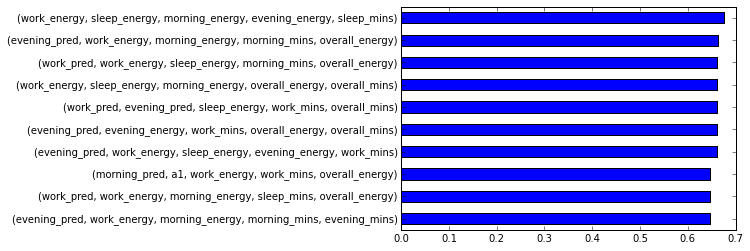

In [41]:
d[i].tail(10).plot(kind='barh')

In [28]:
%matplotlib inline

[ 0.06009366  0.06730823  0.05307294  0.07850144  0.03900158  0.05760933
  0.04636315  0.08423316  0.05870623  0.04337079  0.04052159  0.04329365
  0.06788752  0.07300866  0.07475464  0.06858294  0.04369048]


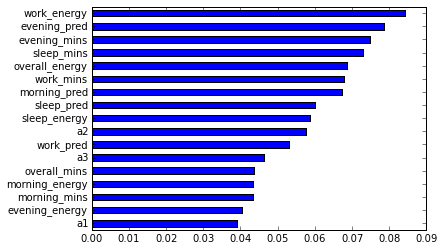

In [67]:
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(df[features], df["hvac_class"])
# display the relative importance of each attribute
print(model.feature_importances_)
ser = pd.Series(model.feature_importances_, index=features)
ser.sort()
ser.plot(kind='barh')

In [61]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn import svm
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

In [ ]:
classifier.fit(train[features], train["hvac_class"])
pred_1 = classifier.pred(test[features])

In [166]:
y2_best_score, y1_best_score, best_random_score, best_random_state

(0.75, 0.75757575757575757, 1.5075757575757576, 1)

In [167]:
import operator
sorted_fold1 = sorted(out_fold1[1]["RF"].items(), key=operator.itemgetter(1))
sorted_fold2 = sorted(out_fold2[1]["RF"].items(), key=operator.itemgetter(1))

In [15]:
d[0]

sleep_pred    morning_pred  work_pred     evening_pred  a1  a3  work_energy  sleep_energy  morning_energy  evening_energy  morning_mins    work_mins     sleep_mins  evening_mins  overall_energy  overall_mins      0.446023
                                                            a2  a3           work_energy   sleep_energy    morning_energy  evening_energy  morning_mins  sleep_mins  evening_mins  overall_energy  overall_mins      0.476326
                                                        a2  a3  work_energy  sleep_energy  morning_energy  evening_energy  morning_mins    work_mins     sleep_mins  evening_mins  overall_energy  overall_mins      0.507576
                                                        a1  a2  a3           work_energy   sleep_energy    morning_energy  evening_energy  morning_mins  work_mins   sleep_mins    evening_mins    overall_mins      0.508049
                                                                                                                

In [104]:
d[0].index[-1]

('work_pred', 'work_energy', 'work_mins', 'sleep_mins', 'overall_mins')

In [103]:
np.random.seed(42)
feature_to_use = list(d[0].index.values[-1])
clf = RandomForestClassifier()
clf.fit(df.head(33)[feature_to_use], df.head(33)["hvac_class"])
pred_labels = clf.predict(df.tail(33)[feature_to_use])
true_labels = df.tail(33)["hvac_class"]
df_accuracy = pd.DataFrame({"pred":pred_labels, "true":true_labels.values})
print accuracy_score(true_labels, pred_labels)
d1 = pd.DataFrame(confusion_matrix(true_labels, pred_labels))
d1.columns = ["Average", "Bad", "Good"]
d1.index = ["Average", "Bad", "Good"]
d1

0.484848484848


,Average,Bad,Good
Average,4,7,0
Bad,8,12,0
Good,2,0,0


In [50]:
feature_to_use = list(d[2].index.values[-1])
clf = RandomForestClassifier(random_state=1)
clf.fit(df.tail(33)[feature_to_use], df.tail(33)["hvac_class"])
pred_labels = clf.predict(df.tail(33)[feature_to_use])
true_labels = df.head(33)["hvac_class"]
df_accuracy = pd.DataFrame({"pred":pred_labels, "true":true_labels.values})
print accuracy_score(pred_labels, true_labels)
d2 = pd.DataFrame(confusion_matrix(true_labels, pred_labels))
d2.columns = ["Average", "Bad", "Good"]
d2.index = ["Average", "Bad", "Good"]
d2

0.545454545455


,Average,Bad,Good
Average,5,6,0
Bad,6,12,1
Good,0,2,1


In [173]:
d1+d2

,Average,Bad,Good
Average,7,15,0
Bad,8,30,1
Good,0,4,1


In [159]:
feature_to_use

['morning_pred', 'a3', 'morning_mins', 'evening_mins']

In [138]:
clf.fit(df_res.head(32)[['work_energy', 'sleep_energy', 'morning_energy', 'evening_energy']], df_res.head(32)["hvac_class"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [139]:
o = clf.predict(df_res.tail(33)[['work_energy', 'sleep_energy', 'morning_energy', 'evening_energy']])

In [140]:
o

array(['Good', 'Bad', 'Average', 'Good', 'Bad', 'Good', 'Average', 'Good',
       'Bad', 'Good', 'Bad', 'Good', 'Good', 'Bad', 'Bad', 'Good',
       'Average', 'Good', 'Good', 'Good', 'Bad', 'Good', 'Bad', 'Good',
       'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Good'], dtype=object)

In [157]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score

In [142]:
y_true = df_res.tail(33)["hvac_class"]
y_pred = o

In [145]:
precision_score(y_true, y_pred)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.48124098124098119

In [143]:
confusion_matrix(y_true, y_pred)

array([[ 1,  2,  5],
       [ 2, 10,  4],
       [ 1,  3,  5]])

In [49]:
svr = LinearSVR()

In [83]:
svr.fit(df_res[['overall_mins', 'overall_energy', 'work_energy']], df_res['good_count'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [84]:
o=svr.predict(df_res[['overall_mins', 'overall_energy', 'work_energy']])

In [85]:
np.round(o)

array([ 102.,   77.,   46.,   65.,   90.,   64.,   77.,   40.,   53.,
         56.,   81.,  114.,   80.,   60.,  113.,   74.,   49.,   94.,
         21.,  107.,   85.,  153.,   16.,   56.,   71.,  110.,  110.,
         83.,   65.,   96.,   64.,   64.,   34.,   36.,  105.,  225.,
         48.,   86.,   30.,   84.,   35.,   98.,   65.,   54.,   41.,
         58.,   57.,   16.,   43.,   75.,   55.,   39.,   50.,  156.,
         66.,  123.,   44.,   89.,    4.,   22.,  153.,  176.,   97.,
        166.,   93.,   33.])

In [56]:
import matplotlib.pyplot as plt

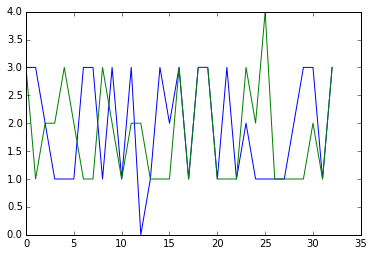

In [99]:
plt.plot(np.round(o))
plt.plot(df_res.tail(33)['good_count'])

In [58]:
%matplotlib inline

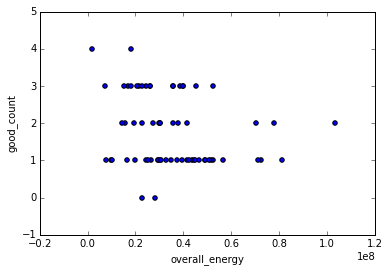

In [64]:
df_res.plot(kind="scatter", x="overall_energy", y="good_count")